#  ECEN 649 Project
## Implementing Viola-Jones Algorithm

In [3]:
'''
    File name: face_detector.py
    Author: Akshay Hiregoudar
    Python Version: 3.7
'''

'\n    File name: face_detector.py\n    Author: Akshay Hiregoudar\n    Python Version: 3.7\n'

In [1]:
import os
import glob
import random
import pickle
from datetime import datetime
from typing import *
from joblib import Parallel, delayed
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from sklearn.metrics import *
import seaborn as sns

# 2.1 Extract Haar Features

In [2]:
# We are given images of 19x19 size
WINDOW_SIZE = 19

In [177]:
Size = NamedTuple('Size', [('height', int), ('width', int)])
Location = NamedTuple('Location', [('top', int), ('left', int)])
ThresholdPolarity = NamedTuple('ThresholdPolarity', [('threshold', float), ('polarity', float)])
ClassifierResult = NamedTuple('ClassifierResult', [('threshold', float), ('polarity', int), ('classification_error', float), ('classifier', Callable[[np.ndarray], float])])
WeakClassifier = NamedTuple('WeakClassifier', [('threshold', float), ('polarity', int), ('alpha', float), ('classifier', Callable[[np.ndarray], float])])

In [3]:
# Integral Image
def to_float_array(img: Image.Image) -> np.ndarray:
    return np.array(img).astype(np.float32) / 255.

def to_image(values: np.ndarray) -> Image.Image:
    return Image.fromarray(np.uint8(values * 255.))

def gamma(values: np.ndarray, coeff: float=2.2) -> np.ndarray:
    return values**(1./coeff)

def gleam(values: np.ndarray) -> np.ndarray:
    return np.sum(gamma(values), axis=2) / values.shape[2]

def to_integral(img: np.ndarray) -> np.ndarray:
    integral = np.cumsum(np.cumsum(img, axis=0), axis=1)
    return np.pad(integral, (1, 1), 'constant', constant_values=(0, 0))[:-1, :-1]

def open_face(path: str, resize: bool=True) -> Image.Image:
    img = Image.open(path)
    img = to_image(gamma(to_float_array(img)))
    return img.convert('L')

In [4]:
# Extract image dataset from local drive
dataset_path = "C:/Users/akyhi/dataset/"

faces_dir = os.path.join(dataset_path, "./trainset/faces")
face_image_files = glob.glob(os.path.join(faces_dir, '**', '*.png'), recursive=True)
nofaces_dir = os.path.join(dataset_path, "./trainset/non-faces")
noface_image_files = glob.glob(os.path.join(nofaces_dir, '**', '*.png'), recursive=True)

test_faces_dir = os.path.join(dataset_path, "./testset/faces")
test_face_image_files = glob.glob(os.path.join(test_faces_dir, '**', '*.png'), recursive=True)
test_nofaces_dir = os.path.join(dataset_path, "./testset/non-faces")
test_noface_image_files = glob.glob(os.path.join(test_nofaces_dir, '**', '*.png'), recursive=True)

In [5]:
# Define Box
class Box:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.coords_x = [x, x + width, x,          x + width]
        self.coords_y = [y, y,         y + height, y + height]
        self.coeffs   = [1, -1,        -1,         1]
    
    def __call__(self, integral_image: np.ndarray) -> float:
        return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))

In [6]:
# Define Feature
class Feature:
    def __init__(self, x: int, y: int, width: int, height: int):
        self.x = x
        self.y = y
        self.width = width
        self.height = height
    
    def __call__(self, integral_image: np.ndarray) -> float:
        try:
            return np.sum(np.multiply(integral_image[self.coords_y, self.coords_x], self.coeffs))
        except IndexError as e:
            raise IndexError(str(e) + ' in ' + str(self))
    
    def __repr__(self):
        return f'{self.__class__.__name__}(x={self.x}, y={self.y}, width={self.width}, height={self.height})'

In [7]:
# Define the five different features
class Feature2h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + height, y + height,
                         y,      y,          y + height, y + height]
        self.coeffs   = [1,     -1,         -1,          1,
                         -1,     1,          1,         -1]

class Feature2v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hh = height // 2        
        self.coords_x = [x,      x + width,  x,          x + width,
                         x,      x + width,  x,          x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [-1,     1,          1,         -1,
                         1,     -1,         -1,          1]

class Feature3h(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        tw = width // 3
        self.coords_x = [x,        x + tw,    x,          x + tw,
                         x + tw,   x + 2*tw,  x + tw,     x + 2*tw,
                         x + 2*tw, x + width, x + 2*tw,   x + width]
        self.coords_y = [y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height,
                         y,        y,         y + height, y + height]
        self.coeffs   = [-1,       1,         1,         -1,
                          1,      -1,        -1,          1,
                         -1,       1,         1,         -1]

class Feature3v(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        th = height // 3
        self.coords_x = [x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width,
                         x,        x + width,  x,          x + width]
        self.coords_y = [y,        y,          y + th,     y + th,
                         y + th,   y + th,     y + 2*th,   y + 2*th,
                         y + 2*th, y + 2*th,   y + height, y + height]
        self.coeffs   = [-1,        1,         1,         -1,
                          1,       -1,        -1,          1,
                         -1,        1,         1,         -1]

class Feature4(Feature):
    def __init__(self, x: int, y: int, width: int, height: int):
        super().__init__(x, y, width, height)
        hw = width // 2
        hh = height // 2
        self.coords_x = [x,      x + hw,     x,          x + hw,     # upper row
                         x + hw, x + width,  x + hw,     x + width,
                         x,      x + hw,     x,          x + hw,     # lower row
                         x + hw, x + width,  x + hw,     x + width]
        self.coords_y = [y,      y,          y + hh,     y + hh,     # upper row
                         y,      y,          y + hh,     y + hh,
                         y + hh, y + hh,     y + height, y + height, # lower row
                         y + hh, y + hh,     y + height, y + height]
        self.coeffs   = [ 1,     -1,         -1,          1,          # upper row
                         -1,      1,          1,         -1,
                         -1,      1,          1,         -1,          # lower row
                          1,     -1,         -1,          1]


In [8]:
def possible_position(size: int, window_size: int = WINDOW_SIZE) -> Iterable[int]:
    return range(0, window_size - size + 1)

def possible_locations(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Location]:
    return (Location(left=x, top=y)
            for x in possible_position(base_shape.width, window_size) 
            for y in possible_position(base_shape.height, window_size))

def possible_shapes(base_shape: Size, window_size: int = WINDOW_SIZE) -> Iterable[Size]:
    base_height = base_shape.height
    base_width = base_shape.width
    return (Size(height=height, width=width)
            for width in range(base_width, window_size + 1, base_width)
            for height in range(base_height, window_size + 1, base_height))

In [33]:
# Obtain total number of haar features
feature2h = list(Feature2h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature2v = list(Feature2v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3h = list(Feature3h(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=1, width=3), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature3v = list(Feature3v(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=3, width=1), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

feature4  = list(Feature4(location.left, location.top, shape.width, shape.height)
                 for shape in possible_shapes(Size(height=2, width=2), WINDOW_SIZE)
                 for location in possible_locations(shape, WINDOW_SIZE))

total_features = feature2h + feature2v + feature3h + feature3v + feature4

print('Toal number of Type 1 (2h) features is', len(feature2h))
print('Toal number of Type 2 (2v) features is', len(feature2v))
print('Toal number of Type 3 (3h) features is', len(feature3h))
print('Toal number of Type 4 (3v) features is', len(feature3v))
print('Toal number of Type 5 (4) features is', len(feature4))

print('Toal number of features is', len(total_features))

Toal number of Type 1 (2h) features is 17100
Toal number of Type 2 (2v) features is 17100
Toal number of Type 3 (3h) features is 10830
Toal number of Type 4 (3v) features is 10830
Toal number of Type 5 (4) features is 8100
Toal number of features is 63960


# 2.2 Build your AdaBoost dectector

In [10]:
# Train the data
def train_data():
    xs = []
    xs.extend([to_float_array(open_face(f)) for f in face_image_files])
    xs.extend([to_float_array(open_face(f)) for f in noface_image_files])
    p = len(face_image_files)
    n = len(noface_image_files)
    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In [ ]:
# Test the data
def test_data():
    xs = []
    xs.extend([to_float_array(open_face(f)) for f in test_face_image_files])
    xs.extend([to_float_array(open_face(f)) for f in test_noface_image_files])
    p = len(test_face_image_files)
    n = len(test_noface_image_files)
    ys = np.hstack([np.ones((p,)), np.zeros((n,))])
    return np.array(xs), ys

In [ ]:
xs, _ = train_data()

train_mean = xs.mean()
train_std = xs.std()
del xs
del _

test_xs, _ = test_data()

test_mean = test_xs.mean()
test_std = test_xs.std()
del test_xs
del _

In [ ]:
# Normalize the data
def normalize(im: np.ndarray, mean: float = train_mean, std: float = train_std) -> np.ndarray:
    return (im - mean) / std

def train_data_normalized(mean: float = train_mean, std: float = train_std) -> Tuple[np.ndarray, np.ndarray]:
    xs, ys = train_data()
    xs = normalize(xs, mean, std)
    return xs, ys

def test_data_normalized(mean: float = test_mean, std: float = test_std) -> Tuple[np.ndarray, np.ndarray]:
    test_xs, test_ys = test_data()
    test_xs = normalize(test_xs, mean, std)
    return test_xs, test_ys

### Adaptive Boosting

#### This is done considering the empirical error

In [291]:
# Weak classifier
def weak_classifier(x: np.ndarray, f: Feature, polarity: float, theta: float) -> float:
    # return 1, if (polarity * f(x)) < (polarity * theta) else 0.
    return (np.sign((polarity * theta) - (polarity * f(x))) + 1) // 2

def run_weak_classifier(x: np.ndarray, c: WeakClassifier) -> float:
    return weak_classifier(x=x, f=c.classifier, polarity=c.polarity, theta=c.threshold)

In [292]:
# Strong Classifier
def strong_classifier(x: np.ndarray, weak_classifiers: List[WeakClassifier]) -> int:
    sum_hypotheses = 0.
    sum_alphas = 0.
    for c in weak_classifiers:
        sum_hypotheses += c.alpha * run_weak_classifier(x, c)
        sum_alphas += c.alpha
    return 1 if (sum_hypotheses >= .5*sum_alphas) else 0

In [293]:
# Normailze the weights
def normalize_weights(w: np.ndarray) -> np.ndarray:
    return w / w.sum()

In [294]:
# Build rectangle based on cumulative row-sum relation as given in the paper
def build_running_sums(ys: np.ndarray, ws: np.ndarray) -> Tuple[float, float, List[float], List[float]]:
    s_minus, s_plus = 0., 0.
    t_minus, t_plus = 0., 0.
    s_minuses, s_pluses = [], []
    
    for y, w in zip(ys, ws):
        if y < .5:
            s_minus += w
            t_minus += w
        else:
            s_plus += w
            t_plus += w
        s_minuses.append(s_minus)
        s_pluses.append(s_plus)
    return t_minus, t_plus, s_minuses, s_pluses

In [295]:
# Find optimum threshold
def find_best_threshold(zs: np.ndarray, t_minus: float, t_plus: float, s_minuses: List[float], s_pluses: List[float]) -> ThresholdPolarity:
    min_e = float('inf')
    min_z, polarity = 0, 0
    for z, s_m, s_p in zip(zs, s_minuses, s_pluses):
        error_1 = s_p + (t_minus - s_m)
        error_2 = s_m + (t_plus - s_p)
        if error_1 < min_e:
            min_e = error_1
            min_z = z
            polarity = -1
        elif error_2 < min_e:
            min_e = error_2
            min_z = z
            polarity = 1
    return ThresholdPolarity(threshold=min_z, polarity=polarity)

In [296]:
# Threshold Polarity
def determine_threshold_polarity(ys: np.ndarray, ws: np.ndarray, zs: np.ndarray) -> ThresholdPolarity:  
    # Sort according to score
    p = np.argsort(zs)
    zs, ys, ws = zs[p], ys[p], ws[p]
    
    # Determine the best threshold: build running sums
    t_minus, t_plus, s_minuses, s_pluses = build_running_sums(ys, ws)
    
    # Determine the best threshold: select optimal threshold.
    return find_best_threshold(zs, t_minus, t_plus, s_minuses, s_pluses)

In [297]:
# Apply the features to classifier
def apply_feature(f: Feature, xis: np.ndarray, ys: np.ndarray, ws: np.ndarray, parallel: Optional[Parallel] = None) -> ClassifierResult:   
    if parallel is None:
        parallel = Parallel(n_jobs=-1, backend='threading')
    
    # Determine all feature values
    zs = np.array(parallel(delayed(f)(x) for x in xis))
    
    # Determine the best threshold
    result = determine_threshold_polarity(ys, ws, zs)
            
    # Determine the classification error
    classification_error = 0.
    for x, y, w in zip(xis, ys, ws):
        h = weak_classifier(x, f, result.polarity, result.threshold)
        classification_error += w * np.abs(h - y)
            
    return ClassifierResult(threshold=result.threshold, polarity=result.polarity, 
                            classification_error=classification_error, classifier=f)

In [299]:
# Define probality
KEEP_PROBABILITY = 1./4

# Weak classifier
def build_weak_classifiers(prefix: str, num_features: int, xis: np.ndarray, ys: np.ndarray, total_features: List[Feature], ws: Optional[np.ndarray] = None) -> Tuple[List[WeakClassifier], List[float]]:
    if ws is None:
        m = len(ys[ys < .5])  # Gives the no.of negative samples
        l = len(ys[ys > .5])  # Gives the no.of positive samples

        # Initialize the weights
        ws = np.zeros_like(ys)
        ws[ys < .5] = 1./(2.*m)
        ws[ys > .5] = 1./(2.*l)
    
    # To keep track of the history of sample weights
    w_history = [ws]

    total_start_time = datetime.now()
    with Parallel(n_jobs=-1, backend='threading') as parallel:
        weak_classifiers = []
        for t in range(num_features):
            print(f'Building weak classifier {t+1}/{num_features} ...')
            start_time = datetime.now()
            
            # Normalize the weights
            ws = normalize_weights(ws)
            
            # Set the output data rate
            status_counter = 2000

            # Select the best weak classifier for this particular round
            best = ClassifierResult(polarity=0, threshold=0, classification_error=float('inf'), classifier=None)
            for i, f in enumerate(total_features):
                status_counter -= 1
                improved = False
                
                if KEEP_PROBABILITY < 1.:
                    skip_probability = np.random.random()
                    if skip_probability > KEEP_PROBABILITY:
                        continue

                result = apply_feature(f, xis, ys, ws, parallel)
                if result.classification_error < best.classification_error:
                    improved = True
                    best = result

                # Print the status every couple of iterations
                if improved or status_counter == 0:
                    current_time = datetime.now()
                    duration = current_time - start_time
                    total_duration = current_time - total_start_time
                    status_counter = STATUS_EVERY
                    if improved:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(total_features)} {100*i/len(total_features):.2f}% evaluated. Classification error improved to {best.classification_error:.5f} using {str(best.classifier)} ...')
                    else:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(total_features)} {100*i/len(total_features):.2f}% evaluated.')

            # Find the value of alpha once the best classifier is found
            beta = best.classification_error / (1 - best.classification_error)
            alpha = np.log(1. / beta)
            
            # Build the weak classifier
            classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.classifier, alpha=alpha)
            
            # Update the weights for misclassified samples
            for i, (x, y) in enumerate(zip(xis, ys)):
                h = run_weak_classifier(x, classifier)
                e = np.abs(h - y)
                ws[i] = ws[i] * np.power(beta, 1-e)
                
            # Register this weak classifier           
            weak_classifiers.append(classifier)
            w_history.append(ws)
        
            pickle.dump(classifier, open(f'{prefix}-weak-learner-{t+1}-of-{num_features}.pickle', 'wb'))
    
    print(f'Done building {num_features} weak classifiers.')
    
    # Output the value of weak classifier
    return weak_classifiers, w_history

In [300]:
# Define total poitive, total negative, false positive, and false negative parameters
PredictionStats = NamedTuple('PredictionStats', [('tn', int), ('fp', int), ('fn', int), ('tp', int)])

def prediction_stats(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[np.ndarray, PredictionStats]:
    c = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c.ravel()
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

In [301]:
xs, ys = train_data_normalized()
xis = np.array([to_integral(x) for x in xs])

In [38]:
# Training the model with one round
assert xis.shape[1:3] == (WINDOW_SIZE+1, WINDOW_SIZE+1), xis.shape
weak_classifiers, w_history = build_weak_classifiers('1st', 1, xis, ys, total_features)
weak_classifiers

Building weak classifier 1/1 ...
t=1/1 0.77s (0.77s in this stage) 2/63960 0.00% evaluated. Classification error improved to 0.35474 using Feature2h(x=0, y=1, width=2, height=1) ...
t=1/1 1.42s (1.41s in this stage) 11/63960 0.02% evaluated. Classification error improved to 0.25923 using Feature2h(x=0, y=10, width=2, height=1) ...
t=1/1 14.67s (14.67s in this stage) 143/63960 0.22% evaluated. Classification error improved to 0.25549 using Feature2h(x=7, y=9, width=2, height=1) ...
t=1/1 16.62s (16.61s in this stage) 156/63960 0.24% evaluated. Classification error improved to 0.17858 using Feature2h(x=8, y=3, width=2, height=1) ...
t=1/1 17.15s (17.14s in this stage) 157/63960 0.24% evaluated. Classification error improved to 0.16439 using Feature2h(x=8, y=4, width=2, height=1) ...
t=1/1 113.41s (113.41s in this stage) 805/63960 1.26% evaluated. Classification error improved to 0.15836 using Feature2h(x=8, y=2, width=2, height=3) ...
t=1/1 114.08s (114.07s in this stage) 806/63960 1.26%

[WeakClassifier(threshold=-1.6022186279296875, polarity=1, alpha=1.829228886822447, classifier=Feature2h(x=8, y=3, width=2, height=10))]

In [39]:
# Testing the above trained model
test_xs, test_ys = test_data_normalized()
test_xis = np.array([to_integral(x) for x in test_xs])

1st stage, classifier0, Precision 0.34, recall 0.30, false positive rate 0.14, false negative rate 0.70.


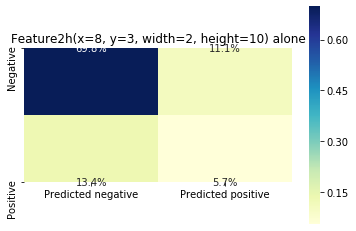

In [42]:
# Performance of the first weak classifier
ys_1 = np.array([run_weak_classifier(x, weak_classifiers[0]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# Plot showing the heatmap of the classifier
plt.title(f'{weak_classifiers[0].classifier} alone');

print(f'1st stage, classifier0, Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

## Drawing the top feature on a test image after 1 round of AdaBoost

In [224]:
cd "./trainset/faces"

C:\Users\akyhi\dataset\trainset\faces


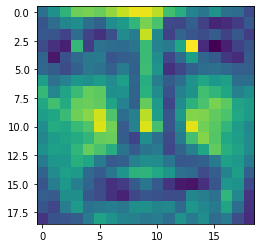

In [225]:
# Display a test image
%matplotlib inline
pil_im = Image.open('face00001.png', 'r')
plt.imshow(np.asarray(pil_im))

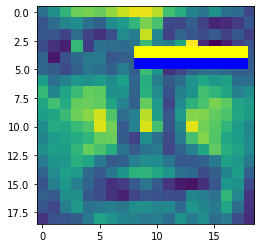

In [226]:
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(pil_im)

# Create patches to represent the top feature
rect_top = patches.Rectangle((8,3),10,1, facecolor='yellow')
rect_bottom = patches.Rectangle((8,4),10,1, facecolor='blue')
# Add the patch to the Axes
ax.add_patch(rect_top)
ax.add_patch(rect_bottom)
plt.show()

Building weak classifier 1/3 ...
t=1/3 0.87s (0.68s in this stage) 3/63960 0.00% evaluated. Classification error improved to 0.39858 using Feature2h(x=0, y=2, width=2, height=1) ...
t=1/3 1.34s (1.15s in this stage) 5/63960 0.01% evaluated. Classification error improved to 0.28303 using Feature2h(x=0, y=4, width=2, height=1) ...
t=1/3 16.36s (16.17s in this stage) 87/63960 0.13% evaluated. Classification error improved to 0.28225 using Feature2h(x=4, y=10, width=2, height=1) ...
t=1/3 21.09s (20.90s in this stage) 104/63960 0.16% evaluated. Classification error improved to 0.22141 using Feature2h(x=5, y=8, width=2, height=1) ...
t=1/3 58.53s (58.34s in this stage) 440/63960 0.69% evaluated. Classification error improved to 0.21386 using Feature2h(x=5, y=7, width=2, height=2) ...
t=1/3 59.05s (58.87s in this stage) 441/63960 0.69% evaluated. Classification error improved to 0.20142 using Feature2h(x=5, y=8, width=2, height=2) ...
t=1/3 67.06s (66.88s in this stage) 494/63960 0.77% evalu

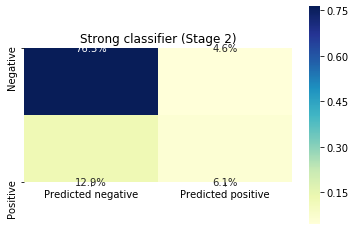

In [44]:
# Detector with 3 rounds of AdaBoost
weak_classifiers_2, w_history_2 = build_weak_classifiers('2nd', 3, xis, ys, total_features)  
weak_classifiers_2

# Performance of the detector
ys_strong = np.array([strong_classifier(x, weak_classifiers_2) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Strong classifier (Stage 2)');

print(f'Combined weak classifiers in the 2nd stage, Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

In [48]:
weak_classifiers_2

[WeakClassifier(threshold=-1.8540043830871582, polarity=1, alpha=1.8083623062531808, classifier=Feature2h(x=8, y=2, width=2, height=12)),
 WeakClassifier(threshold=1.167327880859375, polarity=-1, alpha=1.5787732549614464, classifier=Feature2v(x=15, y=3, width=1, height=4)),
 WeakClassifier(threshold=-0.8468780517578125, polarity=1, alpha=1.3375738113318, classifier=Feature2h(x=11, y=10, width=6, height=1))]

## Drawing the top feature on a test image after 3 rounds of AdaBoost

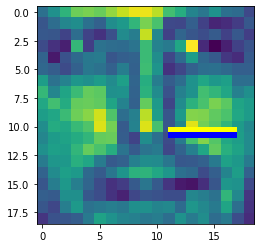

In [231]:
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(pil_im)

# Create patches to represent the top feature
rect_top = patches.Rectangle((11,10),6,0.5, facecolor='yellow')
rect_bottom = patches.Rectangle((11,10.5),6,0.5, facecolor='blue')
# Add the patch to the Axes
ax.add_patch(rect_top)
ax.add_patch(rect_bottom)
plt.show()

Building weak classifier 1/5 ...
t=1/5 0.72s (0.72s in this stage) 6/63960 0.01% evaluated. Classification error improved to 0.34594 using Feature2h(x=0, y=5, width=2, height=1) ...
t=1/5 6.04s (6.03s in this stage) 49/63960 0.08% evaluated. Classification error improved to 0.33956 using Feature2h(x=2, y=10, width=2, height=1) ...
t=1/5 12.22s (12.22s in this stage) 81/63960 0.13% evaluated. Classification error improved to 0.31917 using Feature2h(x=4, y=4, width=2, height=1) ...
t=1/5 13.31s (13.31s in this stage) 91/63960 0.14% evaluated. Classification error improved to 0.31214 using Feature2h(x=4, y=14, width=2, height=1) ...
t=1/5 17.16s (17.16s in this stage) 126/63960 0.20% evaluated. Classification error improved to 0.26401 using Feature2h(x=6, y=11, width=2, height=1) ...
t=1/5 18.70s (18.70s in this stage) 143/63960 0.22% evaluated. Classification error improved to 0.25549 using Feature2h(x=7, y=9, width=2, height=1) ...
t=1/5 20.43s (20.43s in this stage) 157/63960 0.24% eva

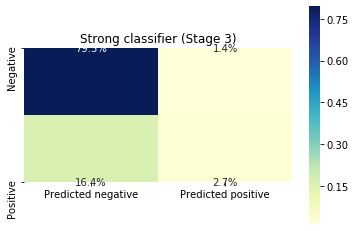

In [45]:
# Detector with 5 rounds of AdaBoost
weak_classifiers_3, w_history_3 = build_weak_classifiers('3rd', 5, xis, ys, total_features)  
weak_classifiers_3

ys_strong = np.array([strong_classifier(x, weak_classifiers_3) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Strong classifier (Stage 3)');

print(f'Combined weak classifiers in the 3rd stage, Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

In [49]:
weak_classifiers_3

[WeakClassifier(threshold=-1.7853279113769531, polarity=1, alpha=1.8759547693628693, classifier=Feature2h(x=8, y=3, width=2, height=8)),
 WeakClassifier(threshold=-2.5864524841308594, polarity=1, alpha=1.4493646531972582, classifier=Feature2h(x=10, y=9, width=8, height=3)),
 WeakClassifier(threshold=3.7308921813964844, polarity=-1, alpha=1.3042395962014504, classifier=Feature2v(x=14, y=3, width=3, height=4)),
 WeakClassifier(threshold=1.0071029663085938, polarity=-1, alpha=1.2311129947786226, classifier=Feature4(x=2, y=15, width=6, height=4)),
 WeakClassifier(threshold=-1.7853279113769531, polarity=1, alpha=1.1226362403886943, classifier=Feature2v(x=12, y=0, width=4, height=2))]

## Drawing the top feature on a test image after 5 rounds of AdaBoost

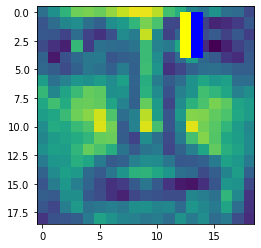

In [246]:
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(pil_im)

# Create patches to represent the top feature
rect_top = patches.Rectangle((12,0),1,4,facecolor='yellow')
rect_bottom = patches.Rectangle((13,0),1,4, facecolor='blue')
                                 
# Add the patch to the Axes
ax.add_patch(rect_top)
ax.add_patch(rect_bottom)
                                 
plt.show()

Building weak classifier 1/10 ...
t=1/10 0.55s (0.55s in this stage) 2/63960 0.00% evaluated. Classification error improved to 0.35474 using Feature2h(x=0, y=1, width=2, height=1) ...
t=1/10 1.08s (1.08s in this stage) 6/63960 0.01% evaluated. Classification error improved to 0.34594 using Feature2h(x=0, y=5, width=2, height=1) ...
t=1/10 4.80s (4.80s in this stage) 28/63960 0.04% evaluated. Classification error improved to 0.31330 using Feature2h(x=1, y=8, width=2, height=1) ...
t=1/10 16.63s (16.62s in this stage) 87/63960 0.13% evaluated. Classification error improved to 0.28225 using Feature2h(x=4, y=10, width=2, height=1) ...
t=1/10 21.24s (21.24s in this stage) 103/63960 0.16% evaluated. Classification error improved to 0.26444 using Feature2h(x=5, y=7, width=2, height=1) ...
t=1/10 32.38s (32.38s in this stage) 143/63960 0.22% evaluated. Classification error improved to 0.25549 using Feature2h(x=7, y=9, width=2, height=1) ...
t=1/10 35.97s (35.97s in this stage) 160/63960 0.25% 

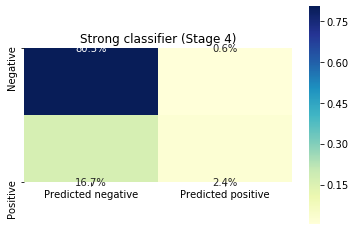

In [46]:
# Detector with 10 rounds of AdaBoost
weak_classifiers_4, w_history_4 = build_weak_classifiers('4th', 10, xis, ys, total_features)  
weak_classifiers_4

ys_strong = np.array([strong_classifier(x, weak_classifiers_4) for x in test_xis])
c, s = prediction_stats(test_ys, ys_strong)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])
plt.title(f'Strong classifier (Stage 4)');

print(f'Combined weak classifiers in the 4th stage, Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

In [50]:
weak_classifiers_4

[WeakClassifier(threshold=-1.9913349151611328, polarity=1, alpha=1.8396373484784911, classifier=Feature2h(x=8, y=2, width=2, height=11)),
 WeakClassifier(threshold=1.167327880859375, polarity=-1, alpha=1.5737257172214119, classifier=Feature2v(x=15, y=3, width=1, height=4)),
 WeakClassifier(threshold=-2.8153457641601562, polarity=1, alpha=1.3501005513489763, classifier=Feature2h(x=11, y=8, width=6, height=4)),
 WeakClassifier(threshold=-0.5265045166015625, polarity=1, alpha=1.2325262920819817, classifier=Feature4(x=12, y=15, width=6, height=2)),
 WeakClassifier(threshold=1.0071029663085938, polarity=-1, alpha=1.1782671832305118, classifier=Feature4(x=2, y=15, width=6, height=4)),
 WeakClassifier(threshold=-3.2273340225219727, polarity=1, alpha=1.1687660567272409, classifier=Feature2v(x=4, y=0, width=13, height=2)),
 WeakClassifier(threshold=3.8911142349243164, polarity=-1, alpha=1.1118127353549987, classifier=Feature2v(x=3, y=2, width=4, height=6)),
 WeakClassifier(threshold=-0.11444091

In [47]:
print(f'Combine weak classifiers in the 3rd stage, Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

Combine weak classifiers in the 3rd stage, Precision 0.80, recall 0.12, false positive rate 0.01, false negative rate 0.88.


## Drawing the top feature on a test image after 10 rounds of AdaBoost

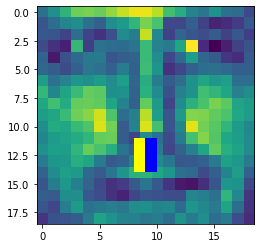

In [245]:
fig,ax = plt.subplots(1)

# Display the image
ax.imshow(pil_im)

# Create patches to represent the top feature
rect_top = patches.Rectangle((8,11),1,3,facecolor='yellow')
rect_bottom = patches.Rectangle((9,11),1,3, facecolor='blue')
                                 
# Add the patch to the Axes
ax.add_patch(rect_top)
ax.add_patch(rect_bottom)
                                 
plt.show()

# 2.3 Adjust the threshold

### AdaBoost done using False Negative as the criteria

In [302]:
# Rewrite the "apply_feature" function with minor changes required for false negative
def apply_feature_fn(f: Feature, xis: np.ndarray, ys: np.ndarray, ws: np.ndarray, parallel: Optional[Parallel] = None) -> ClassifierResult:   
    if parallel is None:
        parallel = Parallel(n_jobs=-1, backend='threading')
    
    # Determine all feature values
    zs = np.array(parallel(delayed(f)(x) for x in xis))
    
    # Determine the best threshold
    result = determine_threshold_polarity(ys, ws, zs)
            
    # Determine the classification error
    classification_error_fn = 0.
    for x, y, w in zip(xis, ys, ws):
        if h != y:
            if y == 1:
                h = weak_classifier(x, f, result.polarity, result.threshold)
                classification_error_fn += w
            
    return ClassifierResult(threshold=result.threshold, polarity=result.polarity, 
                            classification_error=classification_error_fn, classifier=f)

def build_weak_classifiers_fn(prefix: str, num_features: int, xis: np.ndarray, ys: np.ndarray, total_features: List[Feature], ws: Optional[np.ndarray] = None) -> Tuple[List[WeakClassifier], List[float]]:
    if ws is None:
        m = len(ys[ys < .5])  # No.of negative samples
        l = len(ys[ys > .5])  # No.of positive samples

        # Initialize the weights
        ws = np.zeros_like(ys)
        ws[ys < .5] = 1./(2.*m)
        ws[ys > .5] = 1./(2.*l)
    
    # Keep track of the history of the example samples
    w_history = [ws]

    total_start_time = datetime.now()
    with Parallel(n_jobs=-1, backend='threading') as parallel:
        weak_classifiers = []
        for t in range(num_features):
            print(f'Building weak classifier {t+1}/{num_features} ...')
            start_time = datetime.now()
            
            # Normalize the weights
            ws = normalize_weights(ws)
            
            # Set the output data rate
            status_counter = 2000

            # Select the best weak classifier for this particular round
            best = ClassifierResult(polarity=0, threshold=0, classification_error=float('inf'), classifier=None)
            for i, f in enumerate(total_features):
                status_counter -= 1
                improved = False
                
                if KEEP_PROBABILITY < 1.:
                    skip_probability = np.random.random()
                    if skip_probability > KEEP_PROBABILITY:
                        continue

                result = apply_feature_fn(f, xis, ys, ws, parallel)
                if result.classification_error < best.classification_error:
                    improved = True
                    best = result

                # Print status every couple of iterations.
                if improved or status_counter == 0:
                    current_time = datetime.now()
                    duration = current_time - start_time
                    total_duration = current_time - total_start_time
                    status_counter = STATUS_EVERY
                    if improved:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(total_features)} {100*i/len(total_features):.2f}% evaluated. Classification error improved to {best.classification_error:.5f} using {str(best.classifier)} ...')
                    else:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(total_features)} {100*i/len(total_features):.2f}% evaluated.')

            # After the best classifier was found, determine alpha
            beta = best.classification_error / (1 - best.classification_error)
            alpha = np.log(1. / beta)
            
            # Build the weak classifier
            classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.classifier, alpha=alpha)
            
            # Update the weights for misclassified samples
            for i, (x, y) in enumerate(zip(xis, ys)):
                h = run_weak_classifier(x, classifier)
                e = np.abs(h - y)
                ws[i] = ws[i] * np.power(beta, 1-e)
                
            # Register this weak classifier           
            weak_classifiers.append(classifier)
            w_history.append(ws)
        
            pickle.dump(classifier, open(f'{prefix}-weak-learner-{t+1}-of-{num_features}.pickle', 'wb'))
    
    print(f'Done building {num_features} weak classifiers.')
    
    # Output the value of weak classifier
    return weak_classifiers, w_history

PredictionStats = NamedTuple('PredictionStats', [('tn', int), ('fp', int), ('fn', int), ('tp', int)])

def prediction_stats_fp(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[np.ndarray, PredictionStats]:
    c = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c.ravel()
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

xs, ys = train_data_normalized()
xis = np.array([to_integral(x) for x in xs])

In [304]:
# Training the model with 5 rounds with False Negative as the criteria
assert xis.shape[1:3] == (WINDOW_SIZE+1, WINDOW_SIZE+1), xis.shape
weak_classifiers, w_history = build_weak_classifiers('1st', 5, xis, ys, total_features)
weak_classifiers

Building weak classifier 1/5 ...
t=1/5 0.55s (0.55s in this stage) 7/63960 0.01% evaluated. Classification error improved to 0.40198 using Feature2h(x=0, y=6, width=2, height=1) ...
t=1/5 1.14s (1.14s in this stage) 9/63960 0.01% evaluated. Classification error improved to 0.27074 using Feature2h(x=0, y=8, width=2, height=1) ...
t=1/5 1.77s (1.77s in this stage) 10/63960 0.01% evaluated. Classification error improved to 0.26198 using Feature2h(x=0, y=9, width=2, height=1) ...
t=1/5 2.28s (2.28s in this stage) 11/63960 0.02% evaluated. Classification error improved to 0.25923 using Feature2h(x=0, y=10, width=2, height=1) ...
t=1/5 28.61s (28.61s in this stage) 240/63960 0.37% evaluated. Classification error improved to 0.23347 using Feature2h(x=12, y=11, width=2, height=1) ...
t=1/5 59.04s (59.04s in this stage) 441/63960 0.69% evaluated. Classification error improved to 0.20142 using Feature2h(x=5, y=8, width=2, height=2) ...
t=1/5 64.86s (64.86s in this stage) 490/63960 0.76% evaluate

[WeakClassifier(threshold=-1.7853279113769531, polarity=1, alpha=1.8759547693628693, classifier=Feature2h(x=8, y=3, width=2, height=8)),
 WeakClassifier(threshold=1.167327880859375, polarity=-1, alpha=1.5281917624322496, classifier=Feature2v(x=15, y=3, width=1, height=4)),
 WeakClassifier(threshold=-1.4420166015625, polarity=1, alpha=1.4548362758905116, classifier=Feature2h(x=11, y=9, width=6, height=2)),
 WeakClassifier(threshold=1.1902389526367188, polarity=-1, alpha=1.175269987430275, classifier=Feature4(x=2, y=15, width=6, height=4)),
 WeakClassifier(threshold=-1.8997763395309448, polarity=1, alpha=1.1651622487170241, classifier=Feature2v(x=13, y=0, width=3, height=2))]

In [305]:
# Testing the above trained model
test_xs, test_ys = test_data_normalized()
test_xis = np.array([to_integral(x) for x in test_xs])

1st stage, classifier0, Precision 0.36, recall 0.24, false positive rate 0.10, false negative rate 0.76.


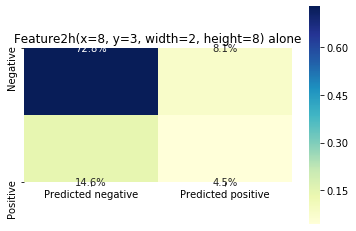

In [306]:
# Performance of the first weak classifier
ys_1 = np.array([run_weak_classifier(x, weak_classifiers[0]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# Plot showing the heatmap of the classifier
plt.title(f'{weak_classifiers[0].classifier} alone');

print(f'1st stage, classifier0, Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

## AdaBoost done using False Positive as the criteria

In [307]:
# Rewrite the "apply_feature" function with minor changes required for false positive
def apply_feature_fp(f: Feature, xis: np.ndarray, ys: np.ndarray, ws: np.ndarray, parallel: Optional[Parallel] = None) -> ClassifierResult:   
    if parallel is None:
        parallel = Parallel(n_jobs=-1, backend='threading')
    
    # Determine all feature values
    zs = np.array(parallel(delayed(f)(x) for x in xis))
    
    # Determine the best threshold
    result = determine_threshold_polarity(ys, ws, zs)
            
    # Determine the classification error
    classification_error_fp = 0.
    for x, y, w in zip(xis, ys, ws):
        if h != y:
            if y != 1:
                h = weak_classifier(x, f, result.polarity, result.threshold)
                classification_error_fp += w
            
    return ClassifierResult(threshold=result.threshold, polarity=result.polarity, 
                            classification_error=classification_error_fp, classifier=f)

def build_weak_classifiers_fp(prefix: str, num_features: int, xis: np.ndarray, ys: np.ndarray, total_features: List[Feature], ws: Optional[np.ndarray] = None) -> Tuple[List[WeakClassifier], List[float]]:
    if ws is None:
        m = len(ys[ys < .5])  # No.of negative examples
        l = len(ys[ys > .5])  # No.of positive examples

        # Initialize the weights
        ws = np.zeros_like(ys)
        ws[ys < .5] = 1./(2.*m)
        ws[ys > .5] = 1./(2.*l)
    
    # Keep track of the history of the example weights.
    w_history = [ws]

    total_start_time = datetime.now()
    with Parallel(n_jobs=-1, backend='threading') as parallel:
        weak_classifiers = []
        for t in range(num_features):
            print(f'Building weak classifier {t+1}/{num_features} ...')
            start_time = datetime.now()
            
            # Normalize the weights
            ws = normalize_weights(ws)
            
            # Set the output data rate
            status_counter = 2000

            # Select the best weak classifier for this particular round
            best = ClassifierResult(polarity=0, threshold=0, classification_error=float('inf'), classifier=None)
            for i, f in enumerate(total_features):
                status_counter -= 1
                improved = False
                
                if KEEP_PROBABILITY < 1.:
                    skip_probability = np.random.random()
                    if skip_probability > KEEP_PROBABILITY:
                        continue

                result = apply_feature_fn(f, xis, ys, ws, parallel)
                if result.classification_error < best.classification_error:
                    improved = True
                    best = result

                # Print status every couple of iterations.
                if improved or status_counter == 0:
                    current_time = datetime.now()
                    duration = current_time - start_time
                    total_duration = current_time - total_start_time
                    status_counter = STATUS_EVERY
                    if improved:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(total_features)} {100*i/len(total_features):.2f}% evaluated. Classification error improved to {best.classification_error:.5f} using {str(best.classifier)} ...')
                    else:
                        print(f't={t+1}/{num_features} {total_duration.total_seconds():.2f}s ({duration.total_seconds():.2f}s in this stage) {i+1}/{len(total_features)} {100*i/len(total_features):.2f}% evaluated.')

            # After the best classifier was found, determine alpha
            beta = best.classification_error / (1 - best.classification_error)
            alpha = np.log(1. / beta)
            
            # Build the weak classifier
            classifier = WeakClassifier(threshold=best.threshold, polarity=best.polarity, classifier=best.classifier, alpha=alpha)
            
            # Update the weights for misclassified samples
            for i, (x, y) in enumerate(zip(xis, ys)):
                h = run_weak_classifier(x, classifier)
                e = np.abs(h - y)
                ws[i] = ws[i] * np.power(beta, 1-e)
                
            # Register this weak classifier           
            weak_classifiers.append(classifier)
            w_history.append(ws)
        
            pickle.dump(classifier, open(f'{prefix}-weak-learner-{t+1}-of-{num_features}.pickle', 'wb'))
    
    print(f'Done building {num_features} weak classifiers.')
    
    # Output the value of weak classifier
    return weak_classifiers, w_history

PredictionStats = NamedTuple('PredictionStats', [('tn', int), ('fp', int), ('fn', int), ('tp', int)])

def prediction_stats_fp(y_true: np.ndarray, y_pred: np.ndarray) -> Tuple[np.ndarray, PredictionStats]:
    c = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = c.ravel()
    return c, PredictionStats(tn=tn, fp=fp, fn=fn, tp=tp)

xs, ys = train_data_normalized()
xis = np.array([to_integral(x) for x in xs])

In [308]:
# Training the model with 5 rounds with False Positive as the criteria
assert xis.shape[1:3] == (WINDOW_SIZE+1, WINDOW_SIZE+1), xis.shape
weak_classifiers, w_history = build_weak_classifiers('1st', 5, xis, ys, total_features)
weak_classifiers

Building weak classifier 1/5 ...
t=1/5 0.60s (0.60s in this stage) 7/63960 0.01% evaluated. Classification error improved to 0.40198 using Feature2h(x=0, y=6, width=2, height=1) ...
t=1/5 1.13s (1.13s in this stage) 10/63960 0.01% evaluated. Classification error improved to 0.26198 using Feature2h(x=0, y=9, width=2, height=1) ...
t=1/5 4.78s (4.78s in this stage) 30/63960 0.05% evaluated. Classification error improved to 0.25991 using Feature2h(x=1, y=10, width=2, height=1) ...
t=1/5 13.97s (13.97s in this stage) 107/63960 0.17% evaluated. Classification error improved to 0.25729 using Feature2h(x=5, y=11, width=2, height=1) ...
t=1/5 16.86s (16.86s in this stage) 136/63960 0.21% evaluated. Classification error improved to 0.24594 using Feature2h(x=7, y=2, width=2, height=1) ...
t=1/5 17.96s (17.96s in this stage) 158/63960 0.25% evaluated. Classification error improved to 0.17639 using Feature2h(x=8, y=5, width=2, height=1) ...
t=1/5 64.91s (64.91s in this stage) 492/63960 0.77% evalu

[WeakClassifier(threshold=-1.8997753858566284, polarity=1, alpha=1.8313278845229832, classifier=Feature2h(x=8, y=1, width=2, height=11)),
 WeakClassifier(threshold=4.509128570556641, polarity=-1, alpha=1.4409610333288565, classifier=Feature2v(x=14, y=3, width=5, height=4)),
 WeakClassifier(threshold=-4.898223876953125, polarity=1, alpha=1.3371865403563843, classifier=Feature4(x=4, y=0, width=4, height=12)),
 WeakClassifier(threshold=-1.075775146484375, polarity=1, alpha=1.2577640389475058, classifier=Feature2v(x=13, y=0, width=2, height=2)),
 WeakClassifier(threshold=0.686676025390625, polarity=-1, alpha=1.259969284122591, classifier=Feature2v(x=5, y=15, width=2, height=4))]

In [309]:
# Testing the above trained model
test_xs, test_ys = test_data_normalized()
test_xis = np.array([to_integral(x) for x in test_xs])

1st stage, classifier0, Precision 0.37, recall 0.32, false positive rate 0.13, false negative rate 0.68.


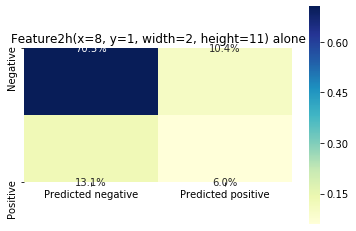

In [310]:
# Performance of the weak classifier
ys_1 = np.array([run_weak_classifier(x, weak_classifiers[0]) for x in test_xis])
c, s = prediction_stats(test_ys, ys_1)

sns.heatmap(c / c.sum(), cmap='YlGnBu', annot=True, square=True, fmt='.1%',
            xticklabels=['Predicted negative', 'Predicted positive'], 
            yticklabels=['Negative', 'Positive'])

# Plot showing the heatmap of the classifier
plt.title(f'{weak_classifiers[0].classifier} alone');

print(f'1st stage, classifier0, Precision {s.tp/(s.tp+s.fp):.2f}, recall {s.tp/(s.tp+s.fn):.2f}, false positive rate {s.fp/(s.fp+s.tn):.2f}, false negative rate {s.fn/(s.tp+s.fn):.2f}.')

# 2.4 Additional Part
## 2.4.2 Detecting in real-world photos

The goal is to use the cascade method to build a classifer for face detection.

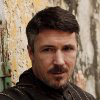

In [106]:
# Load an image from the given additional images
image_path = "baelish.jpg"
image = Image.open(image_path)
image

#### Pre-processing of the image for face detection

In [110]:
# Convert the image to an array
image_array = to_float_array(image)

print('Value range: {0} .. {1}'.format(image_array.min(), image_array.max()))

Value range: 0.0 .. 0.9764705896377563


In [111]:
# Convert the image to an greyscale image
grayscale = gleam(image_array)

print('Grayscale value range: {0} .. {1}'.format(grayscale.min(), grayscale.max()))

Grayscale value range: 0.0 .. 0.938406229019165


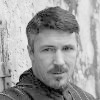

In [112]:
# Display greyscale image

to_image(grayscale)

#### Implement the cascade method.

Here I will be implenting a 4 stage cascade method with 1,3,5, and 10 rounds of AdaBoost respectively.

In [469]:
# Define window size based on the size of the faces in the image
WINDOW_SIZE = 60

In [470]:
integral = to_integral(grayscale)
rows, cols = integral.shape[0:2]
HALF_WINDOW = WINDOW_SIZE // 2

face_positions_1 = []
face_positions_2 = []
face_positions_3 = []
face_positions_4 = []

normalized_integral = to_integral(normalize(grayscale))

for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW):
    for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW):
        window = normalized_integral[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
                
        # First cascade stage ( 1 round)
        probably_face = strong_classifier(window, weak_classifiers)
        if probably_face < 0.5:
            continue
        face_positions_1.append((row, col))
            
        # Second cascade stage (3 rounds)
        probably_face = strong_classifier(window, weak_classifiers_2)
        if probably_face < 0.5:
            continue
        face_positions_2.append((row, col))
            
        # Third cascade stage (5 rounds)
        probably_face = strong_classifier(window, weak_classifiers_3)
        if probably_face < 0.5:
            continue
        face_positions_3.append((row, col))
        
        # Fourth cascade stage (10 rounds)
        probably_face = strong_classifier(window, weak_classifiers_4)
        if probably_face < 0.5:
            continue
        face_positions_4.append((row, col))
    
print(f'Found {len(face_positions_1)} candidates at stage 1, {len(face_positions_2)} at stage 2, {len(face_positions_3)} at stage 3, and {len(face_positions_4)} at stage 4.')

Found 52 candidates at stage 1, 12 at stage 2, 9 at stage 3, and 4 at stage 4.


In [471]:
def render_candidates(image: Image.Image, candidates: List[Tuple[int, int]]) -> Image.Image:
    canvas = to_float_array(image.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return to_image(canvas)

### Display the processed images

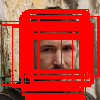

In [472]:
# Output the image with rectangles on it
render_candidates(image, face_positions_1)

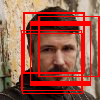

In [473]:
render_candidates(image, face_positions_2)

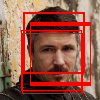

In [474]:
render_candidates(image, face_positions_3)

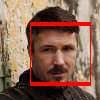

In [475]:
render_candidates(image, face_positions_4)

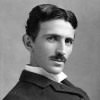

In [331]:
# Load a different image
image_2_path = "tesla.jpg"
image_2 = Image.open(image_2_path)
image_2

Value range: 0.0 .. 1.0
Grayscale value range: 0.0 .. 1.0


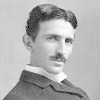

In [516]:
# Convert the image to an array
image_2_array = to_float_array(image_2)

print('Value range: {0} .. {1}'.format(image_2_array.min(), image_2_array.max()))

# Convert the image to an greyscale image
grayscale_2 = gleam(image_2_array)

print('Grayscale value range: {0} .. {1}'.format(grayscale_2.min(), grayscale_2.max()))

# Display greyscale image
to_image(grayscale_2)

In [509]:
WINDOW_SIZE = 60

In [517]:
integral_2 = to_integral(grayscale_2)
rows, cols = integral_2.shape[0:2]
HALF_WINDOW = WINDOW_SIZE // 2

face_positions_1 = []
face_positions_2 = []
face_positions_3 = []
face_positions_4 = []

normalized_integral_2 = to_integral(normalize(grayscale_2))

for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW):
    for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW):
        window = normalized_integral_2[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
                
        # First cascade stage ( 1 round)
        probably_face = strong_classifier(window, weak_classifiers)
        if probably_face < 0.5:
            continue
        face_positions_1.append((row, col))
            
        # Second cascade stage (3 rounds)
        probably_face = strong_classifier(window, weak_classifiers_2)
        if probably_face < 0.5:
            continue
        face_positions_2.append((row, col))
            
        # Third cascade stage (5 rounds)
        probably_face = strong_classifier(window, weak_classifiers_3)
        if probably_face < 0.5:
            continue
        face_positions_3.append((row, col))
        
        # Fourth cascade stage (10 rounds)
        probably_face = strong_classifier(window, weak_classifiers_4)
        if probably_face < 0.5:
            continue
        face_positions_4.append((row, col))
    
print(f'Found {len(face_positions_1)} candidates at stage 1, {len(face_positions_2)} at stage 2, {len(face_positions_3)} at stage 3, and {len(face_positions_4)} at stage 4.')

def render_candidates(image_2: Image.Image, candidates: List[Tuple[int, int]]) -> Image.Image:
    canvas = to_float_array(image_2.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return to_image(canvas)

Found 21 candidates at stage 1, 12 at stage 2, 7 at stage 3, and 4 at stage 4.


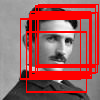

In [518]:
render_candidates(image_2, face_positions_1)

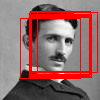

In [519]:
render_candidates(image_2, face_positions_2)

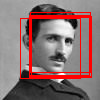

In [520]:
render_candidates(image_2, face_positions_3)

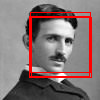

In [521]:
render_candidates(image_2, face_positions_4)

#### Let us now implement this on images with no faces

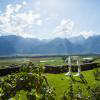

In [562]:
image_3_path = "land.jpeg"
image_3 = Image.open(image_3_path)
image_3

Value range: 0.0 .. 1.0
Grayscale value range: 0.06365162134170532 .. 0.995229959487915


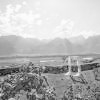

In [563]:
# Convert the image to an array
image_array_3 = to_float_array(image_3)

print('Value range: {0} .. {1}'.format(image_array_3.min(), image_array_3.max()))

# Convert the image to an greyscale image
grayscale_3 = gleam(image_array_3)

print('Grayscale value range: {0} .. {1}'.format(grayscale_3.min(), grayscale_3.max()))

# Display greyscale image
to_image(grayscale_3)

In [564]:
WINDOW_SIZE = 50

integral_3 = to_integral(grayscale_3)
rows, cols = integral_3.shape[0:2]
HALF_WINDOW = WINDOW_SIZE // 2

face_positions_1 = []
face_positions_2 = []
face_positions_3 = []
face_positions_4 = []

normalized_integral_3 = to_integral(normalize(grayscale_3))

for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW):
    for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW):
        window = normalized_integral_3[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
                
        # First cascade stage ( 1 round)
        probably_face = strong_classifier(window, weak_classifiers)
        if probably_face < 0.5:
            continue
        face_positions_1.append((row, col))
            
        # Second cascade stage (3 rounds)
        probably_face = strong_classifier(window, weak_classifiers_2)
        if probably_face < 0.5:
            continue
        face_positions_2.append((row, col))
            
        # Third cascade stage (5 rounds)
        probably_face = strong_classifier(window, weak_classifiers_3)
        if probably_face < 0.5:
            continue
        face_positions_3.append((row, col))
        
        # Fourth cascade stage (10 rounds)
        probably_face = strong_classifier(window, weak_classifiers_4)
        if probably_face < 0.5:
            continue
        face_positions_4.append((row, col))
    
print(f'Found {len(face_positions_1)} candidates at stage 1, {len(face_positions_2)} at stage 2, {len(face_positions_3)} at stage 3, and {len(face_positions_4)} at stage 4.')

def render_candidates(image_3: Image.Image, candidates: List[Tuple[int, int]]) -> Image.Image:
    canvas = to_float_array(image_3.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return to_image(canvas)

Found 0 candidates at stage 1, 0 at stage 2, 0 at stage 3, and 0 at stage 4.


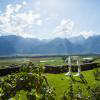

In [565]:
render_candidates(image_3, face_positions_1)

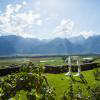

In [566]:
render_candidates(image_3, face_positions_2)

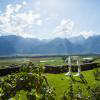

In [567]:
render_candidates(image_3, face_positions_3)

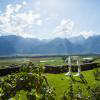

In [568]:
render_candidates(image_3, face_positions_4)

#### We can see that the classifier did not output any face detection in this image as this image does not contain any faces

### Next, we try to implement the classifier on images with multiple faces in them.

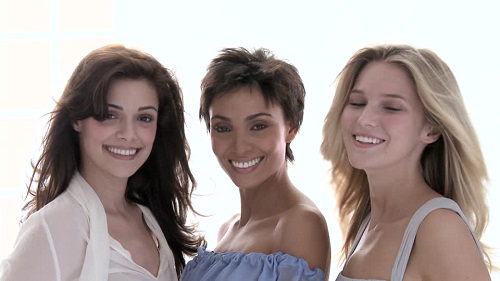

In [582]:
image_4_path = "groupe2.jpg"
image_4 = Image.open(image_4_path)
image_4

Value range: 0.0 .. 1.0
Grayscale value range: 0.0 .. 1.0


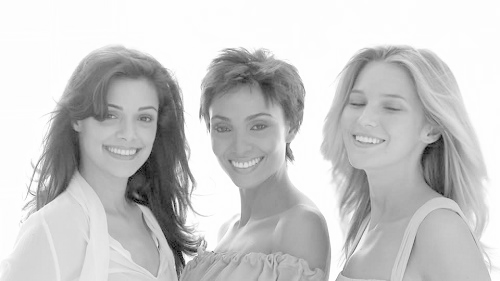

In [583]:
# Convert the image to an array
image_4_array = to_float_array(image_4)

print('Value range: {0} .. {1}'.format(image_4_array.min(), image_4_array.max()))

# Convert the image to an greyscale image
grayscale_4 = gleam(image_4_array)

print('Grayscale value range: {0} .. {1}'.format(grayscale_4.min(), grayscale_4.max()))

# Display greyscale image
to_image(grayscale_4)

In [601]:
WINDOW_SIZE = 120

integral_4 = to_integral(grayscale_4)
rows, cols = integral_4.shape[0:2]
HALF_WINDOW = WINDOW_SIZE // 2

face_positions_1 = []
face_positions_2 = []
face_positions_3 = []
face_positions_4 = []

normalized_integral_4 = to_integral(normalize(grayscale_4))

for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW):
    for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW):
        window = normalized_integral_4[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
                
        # First cascade stage ( 1 round)
        probably_face = strong_classifier(window, weak_classifiers)
        if probably_face < 0.5:
            continue
        face_positions_1.append((row, col))
            
        # Second cascade stage (3 rounds)
        probably_face = strong_classifier(window, weak_classifiers_2)
        if probably_face < 0.5:
            continue
        face_positions_2.append((row, col))
            
        # Third cascade stage (5 rounds)
        probably_face = strong_classifier(window, weak_classifiers_3)
        if probably_face < 0.5:
            continue
        face_positions_3.append((row, col))
        
        # Fourth cascade stage (10 rounds)
        probably_face = strong_classifier(window, weak_classifiers_4)
        if probably_face < 0.5:
            continue
        face_positions_4.append((row, col))
    
print(f'Found {len(face_positions_1)} candidates at stage 1, {len(face_positions_2)} at stage 2, {len(face_positions_3)} at stage 3, and {len(face_positions_4)} at stage 4.')

def render_candidates(image_4: Image.Image, candidates: List[Tuple[int, int]]) -> Image.Image:
    canvas = to_float_array(image_4.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return to_image(canvas)

Found 138 candidates at stage 1, 52 at stage 2, 33 at stage 3, and 12 at stage 4.


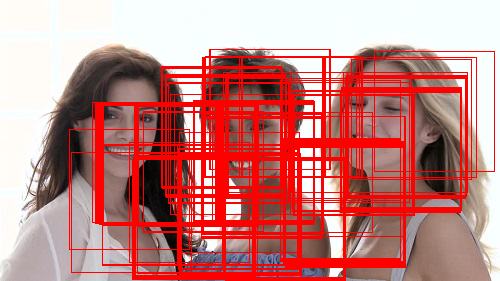

In [602]:
render_candidates(image_4, face_positions_1)

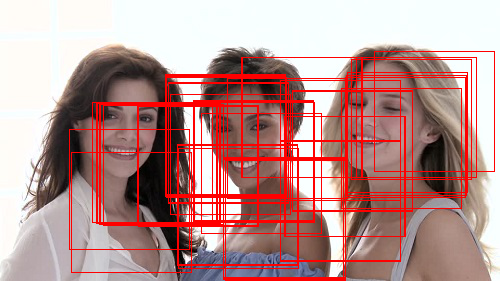

In [603]:
render_candidates(image_4, face_positions_2)

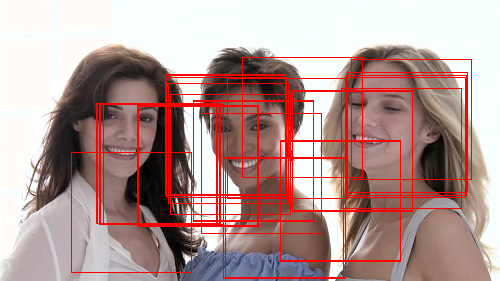

In [604]:
render_candidates(image_4, face_positions_3)

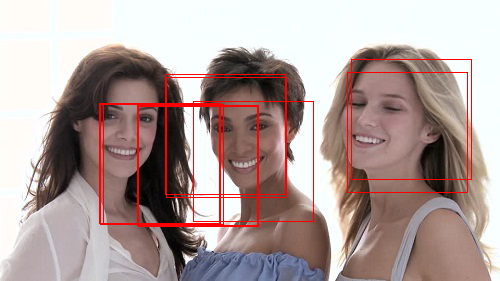

In [605]:
render_candidates(image_4, face_positions_4)

#### Let's do another image contaning multiple faces

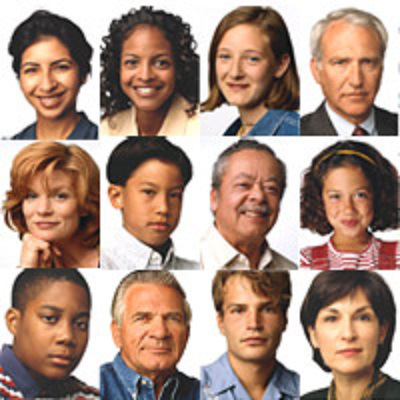

In [641]:
image_5_path = "visages.jpg"
image_5 = Image.open(image_5_path)
image_5

Value range: 0.0 .. 1.0
Grayscale value range: 0.0946722999215126 .. 1.0


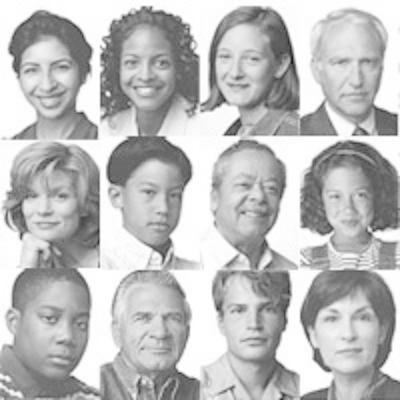

In [642]:
# Convert the image to an array
image_5_array = to_float_array(image_5)

print('Value range: {0} .. {1}'.format(image_5_array.min(), image_5_array.max()))

# Convert the image to an greyscale image
grayscale_5 = gleam(image_5_array)

print('Grayscale value range: {0} .. {1}'.format(grayscale_5.min(), grayscale_5.max()))

# Display greyscale image
to_image(grayscale_5)

In [648]:
WINDOW_SIZE = 100

integral_5 = to_integral(grayscale_5)
rows, cols = integral_5.shape[0:2]
HALF_WINDOW = WINDOW_SIZE // 2

face_positions_1 = []
face_positions_2 = []
face_positions_3 = []
face_positions_4 = []

normalized_integral_5 = to_integral(normalize(grayscale_5))

for row in range(HALF_WINDOW + 1, rows - HALF_WINDOW):
    for col in range(HALF_WINDOW + 1, cols - HALF_WINDOW):
        window = normalized_integral_5[row-HALF_WINDOW-1:row+HALF_WINDOW+1, col-HALF_WINDOW-1:col+HALF_WINDOW+1]
                
        # First cascade stage ( 1 round)
        probably_face = strong_classifier(window, weak_classifiers)
        if probably_face < 0.5:
            continue
        face_positions_1.append((row, col))
            
        # Second cascade stage (3 rounds)
        probably_face = strong_classifier(window, weak_classifiers_2)
        if probably_face < 0.5:
            continue
        face_positions_2.append((row, col))
            
        # Third cascade stage (5 rounds)
        probably_face = strong_classifier(window, weak_classifiers_3)
        if probably_face < 0.5:
            continue
        face_positions_3.append((row, col))
        
        # Fourth cascade stage (10 rounds)
        probably_face = strong_classifier(window, weak_classifiers_4)
        if probably_face < 0.5:
            continue
        face_positions_4.append((row, col))
    
print(f'Found {len(face_positions_1)} candidates at stage 1, {len(face_positions_2)} at stage 2, {len(face_positions_3)} at stage 3, and {len(face_positions_4)} at stage 4.')

def render_candidates(image_5: Image.Image, candidates: List[Tuple[int, int]]) -> Image.Image:
    canvas = to_float_array(image_5.copy())
    for row, col in candidates:
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col-HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1:row+HALF_WINDOW, col+HALF_WINDOW-1, :] = [1., 0., 0.]
        canvas[row-HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
        canvas[row+HALF_WINDOW-1, col-HALF_WINDOW-1:col+HALF_WINDOW, :] = [1., 0., 0.]
    return to_image(canvas)

Found 921 candidates at stage 1, 307 at stage 2, 143 at stage 3, and 61 at stage 4.


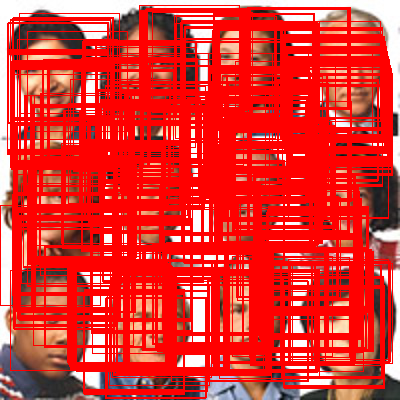

In [649]:
render_candidates(image_5, face_positions_1)

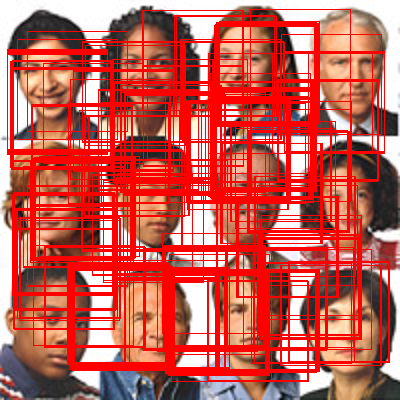

In [650]:
render_candidates(image_5, face_positions_2)

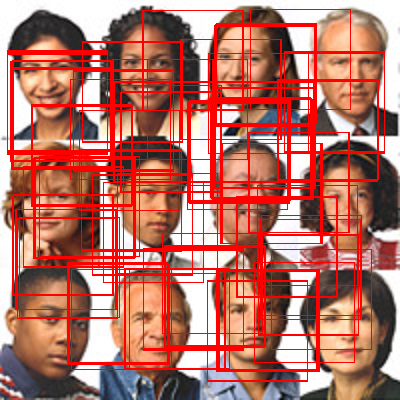

In [651]:
render_candidates(image_5, face_positions_3)

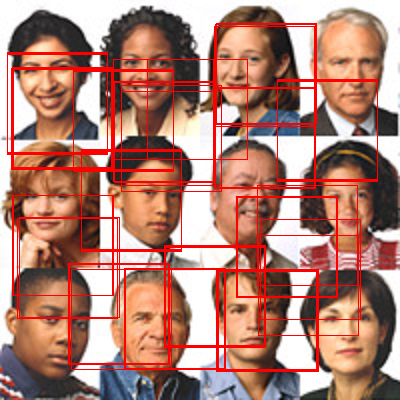

In [652]:
render_candidates(image_5, face_positions_4)